In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

from utils import build_vocab, evaluate_baselines
from models import RecurrentModel, VanillaRNNBlock, GRUBlock, LSTMBlock
from nameTrainer import NameTrainer
from pipeline import ModelRunner
from torchModels import analyze_vanishing_gradient_torch, analyze_vanishing_gradient_torch_name

# Загрузка и анализ данных (#2)

In [32]:
df = pd.read_csv(r'data/babynames-clean.csv', header=None)
df.columns = ['name', "gender"]

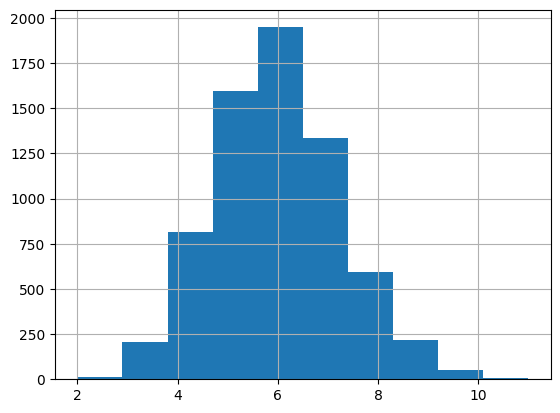

In [ ]:
df.name.str.len().hist();

In [ ]:
df.gender.value_counts()/df.shape[0]*100

gender
boy     50.678266
girl    49.321734
Name: count, dtype: float64

In [33]:
cleaned = df.name.str.strip()
cleaned = df.name.str.lower()

In [144]:
cleaned.str.len().value_counts()

name
6     1948
5     1596
7     1335
4      817
8      591
9      217
3      209
10      52
2       10
11       7
Name: count, dtype: int64

In [9]:
cleaned.str.split("").explode().value_counts()

name
     13564
a     5593
e     5038
n     3524
i     3264
l     3255
r     3070
o     2071
t     1745
s     1674
d     1532
m     1245
y     1243
h     1206
c     1063
u      707
b      673
k      616
g      526
j      502
v      490
f      302
w      271
p      265
z      199
x       71
q       61
Name: count, dtype: int64

# Подготовка данных (№3)

In [34]:
df.gender = (df.gender == "boy")*1

In [36]:
with_tokens = [f"<{name}>" for name in cleaned]
max_len = max(len(s) for s in with_tokens)
padded = [s.ljust(max_len, '.') for s in with_tokens]

In [37]:
max_len

13

In [38]:
tokens, token2id, id2token = build_vocab(padded)

In [40]:
encoded = np.zeros((len(padded), max_len), dtype=np.int64)
    
for i, name in enumerate(padded):
    encoded[i] = [token2id[ch] for ch in name]

In [45]:
X_train, X_temp, y_train, y_temp = train_test_split(
    encoded, df.gender, test_size=0.2, random_state=42, stratify=df.gender
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [46]:
X_train_t = torch.from_numpy(X_train).long()
X_valid_t = torch.from_numpy(X_valid).long()
X_test_t  = torch.from_numpy(X_test).long()

y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
y_valid_t = torch.tensor(y_valid.values, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
valid_dataset = TensorDataset(X_valid_t, y_valid_t)
test_dataset  = TensorDataset(X_test_t,  y_test_t)

In [47]:
BATCH_SIZE = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Next char prediction . №4 & №5 & №6

In [87]:
models_names = ModelRunner(['VanillaRNNBlock', 'GRUBlock', 'LSTMBlock'], len(tokens))

ModelRunner инициализирован для блоков: ['VanillaRNNBlock', 'GRUBlock', 'LSTMBlock']


In [88]:
num_epochs = 200

In [89]:
%%time
models_names.train_models(train_loader, valid_loader, num_epochs, use_next_char_loss = True)


Обучение VanillaRNNBlock...
Epoch 1:next_train=3.2184, next_valid=2.9944
Epoch 10:next_train=2.2717, next_valid=2.2733
Epoch 20:next_train=2.1740, next_valid=2.1838
Epoch 30:next_train=2.1227, next_valid=2.1395
Epoch 40:next_train=2.0858, next_valid=2.1095
Epoch 50:next_train=2.0579, next_valid=2.0881
Epoch 60:next_train=2.0343, next_valid=2.0721
Epoch 70:next_train=2.0132, next_valid=2.0581
Epoch 80:next_train=1.9943, next_valid=2.0465
Epoch 90:next_train=1.9779, next_valid=2.0369
Epoch 100:next_train=1.9628, next_valid=2.0290
Epoch 110:next_train=1.9479, next_valid=2.0201
Epoch 120:next_train=1.9342, next_valid=2.0140
Epoch 130:next_train=1.9208, next_valid=2.0086
Epoch 140:next_train=1.9089, next_valid=2.0026
Epoch 150:next_train=1.8967, next_valid=1.9978
Epoch 160:next_train=1.8854, next_valid=1.9933
Epoch 170:next_train=1.8747, next_valid=1.9904
Epoch 180:next_train=1.8639, next_valid=1.9868
Epoch 190:next_train=1.8540, next_valid=1.9844
Epoch 200:next_train=1.8441, next_valid=1.

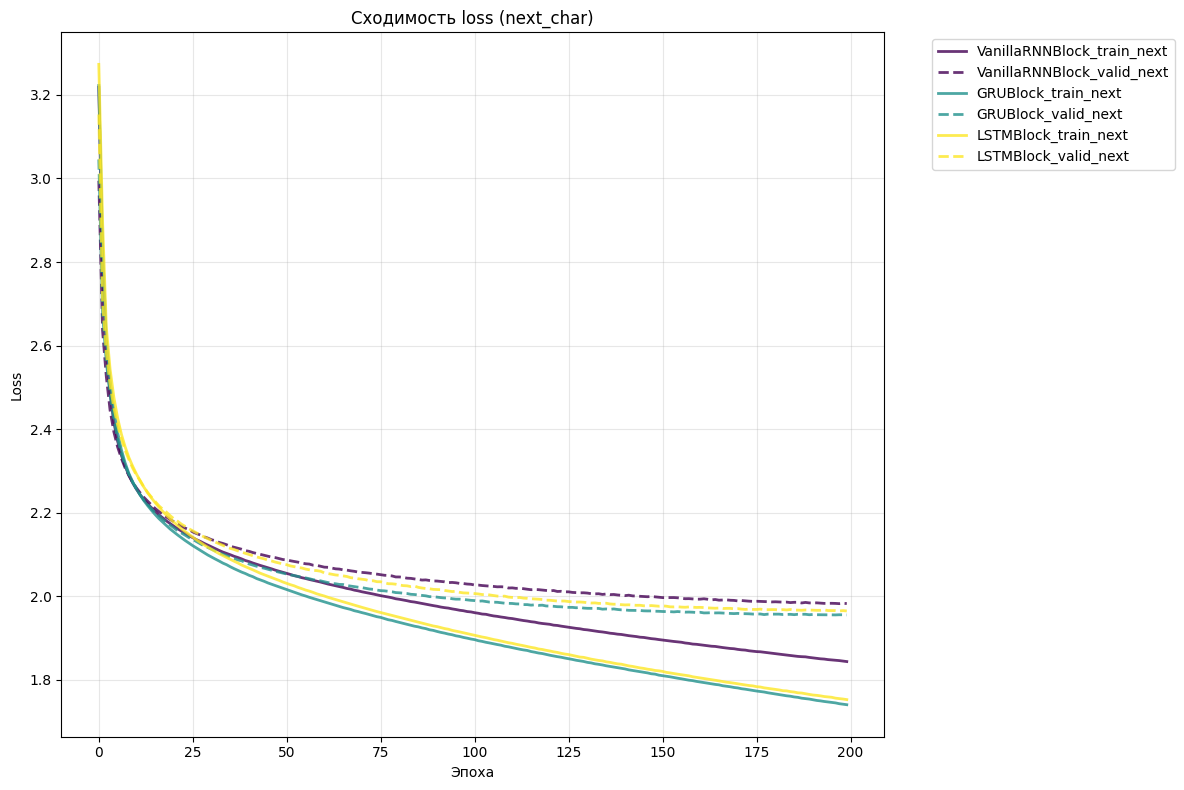

In [94]:
models_names.plot_losses(loss_type='next_char')

In [95]:
models_names.generate_names_comparison(token2id=token2id, id2token=id2token)


Сгенерированные имена:


,temp_0.7,temp_1.0,temp_1.3
VanillaRNNBlock,"lidora, abe, ennino, riles, ashand","restian, ardy, remsie, ala, leman","adalaveuth, oria, ecettie, samalle, renes"
GRUBlock,"eariana, aelia, oley, enes, ayah","oria, obia, arlen, yriean, arie","waey, erik, aydah, edy, avaiy"
LSTMBlock,"elis, amir, elipher, ana, endin","eler, olo, byr, arle, ere","oys, eenor, arena, eulen, aalianiah"


In [91]:
models_names.compute_roc_auc(test_loader)


ROC AUC по моделям:


,train_roc_auc,valid_roc_auc,test_roc_auc
VanillaRNNBlock,0.371,0.359,0.345
GRUBlock,0.689,0.688,0.672
LSTMBlock,0.583,0.631,0.596


# Сравнение моделей по качеству прогнозирования имен (№7)

In [93]:
models_names.compute_perplexity()


Perplexity по моделям:


,ppl_ce,ppl_manual
VanillaRNNBlock,7.2775,7.2775
GRUBlock,7.0664,7.0664
LSTMBlock,7.0371,7.0371


In [100]:
evaluate_baselines(test_loader, len(tokens), token2id)

Random Model PPL: 29.0000
Frequency Model PPL: 16.941


# Классификация по полу (№8)

In [58]:
models_gender = ModelRunner(['VanillaRNNBlock', 'GRUBlock', 'LSTMBlock'], len(tokens))

ModelRunner инициализирован для блоков: ['VanillaRNNBlock', 'GRUBlock', 'LSTMBlock']


In [61]:
models_gender.train_models(train_loader, valid_loader, 25, use_gender_loss = True)


Обучение VanillaRNNBlock...
Epoch 1:, gender_train=0.6919, gender_valid=0.6855
Epoch 10:, gender_train=0.4230, gender_valid=0.4495
Epoch 20:, gender_train=0.3846, gender_valid=0.4283
Epoch 25:, gender_train=0.3785, gender_valid=0.4308
VanillaRNNBlock: обучение завершено

Обучение GRUBlock...
Epoch 1:, gender_train=0.6844, gender_valid=0.6665
Epoch 10:, gender_train=0.4109, gender_valid=0.4480
Epoch 20:, gender_train=0.3755, gender_valid=0.4369
Epoch 25:, gender_train=0.3574, gender_valid=0.4290
GRUBlock: обучение завершено

Обучение LSTMBlock...
Epoch 1:, gender_train=0.6905, gender_valid=0.6832
Epoch 10:, gender_train=0.4155, gender_valid=0.4538
Epoch 20:, gender_train=0.3749, gender_valid=0.4596
Epoch 25:, gender_train=0.3606, gender_valid=0.4439
LSTMBlock: обучение завершено


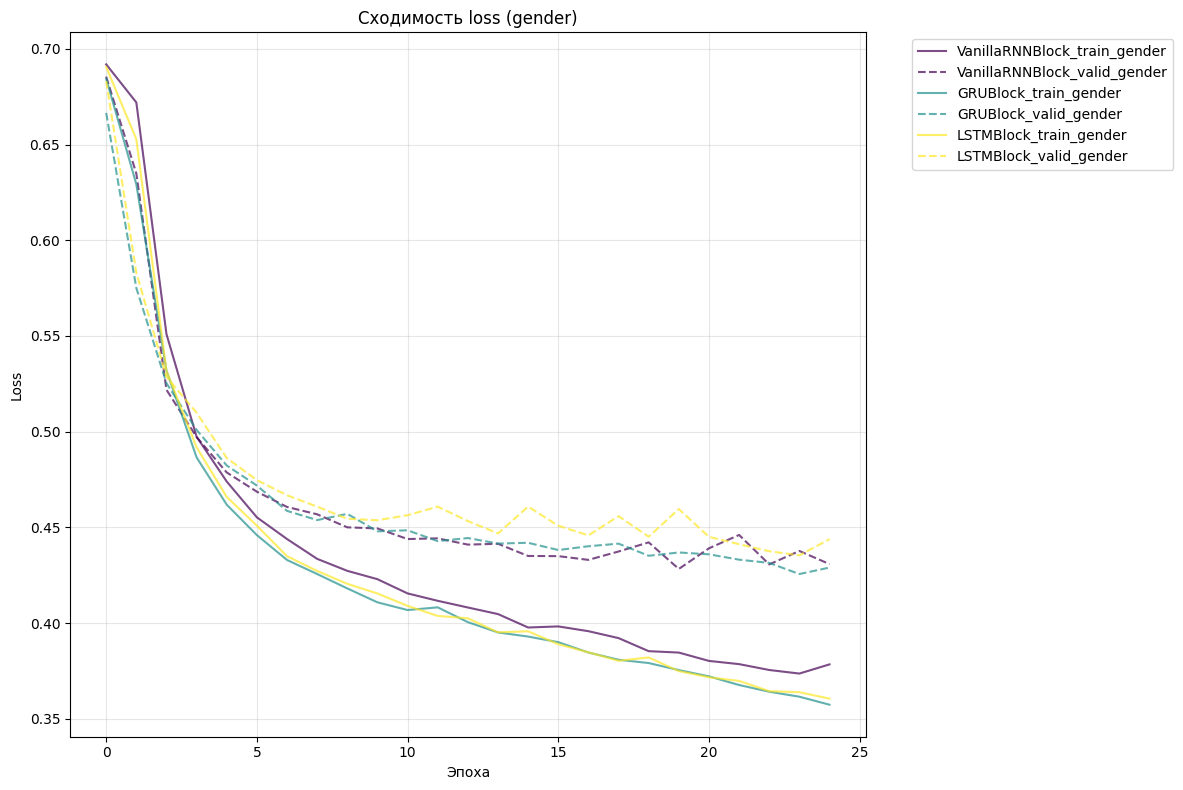

In [62]:
models_gender.plot_losses(loss_type='gender')

In [63]:
models_gender.generate_names_comparison(token2id=token2id, id2token=id2token)


Сгенерированные имена:


,temp_0.7,temp_1.0,temp_1.3
VanillaRNNBlock,"emntptzguptpk, xgisyuhonrccv, , udvfqdbwwu, sv...","e.iuqkygp, lwhanwbafvlmt, dtnxvtgadylw, rsaubz...","vodeildcqegzk, jtjjlakvwwvop, gdlcxfme.afou, f..."
GRUBlock,"imxbdndizjzoq, hk, wxnmjkzbddjyg, x,","tjdwmifzthhkl, godscl.dfozso, owxyfzfygjtgm, m...","kvlrzdwmxzbu, tpcnvdsvgamb, undqqsml.swgw, gej..."
LSTMBlock,"zatdrwevgklof, njmpwxqvjght, sfvojdr, hhxnruzk...","ghvkdrhwcvi.i, spxxkh, oapbiatwjw, huvbxahwpgw...","jnxn, mscrddxlqspak, xv.qnjgff.pn, hqtfhsloywpw,"


In [64]:
models_gender.compute_roc_auc(test_loader)


ROC AUC по моделям:


,train_roc_auc,valid_roc_auc,test_roc_auc
VanillaRNNBlock,0.918,0.880,0.911
GRUBlock,0.923,0.886,0.919
LSTMBlock,0.923,0.878,0.918


# Vanishing Gradient (№9)


=== Анализ Vanishing Gradient Gender ===
Mode length: 6
Training RNN...
Training LSTM...
Training GRU...


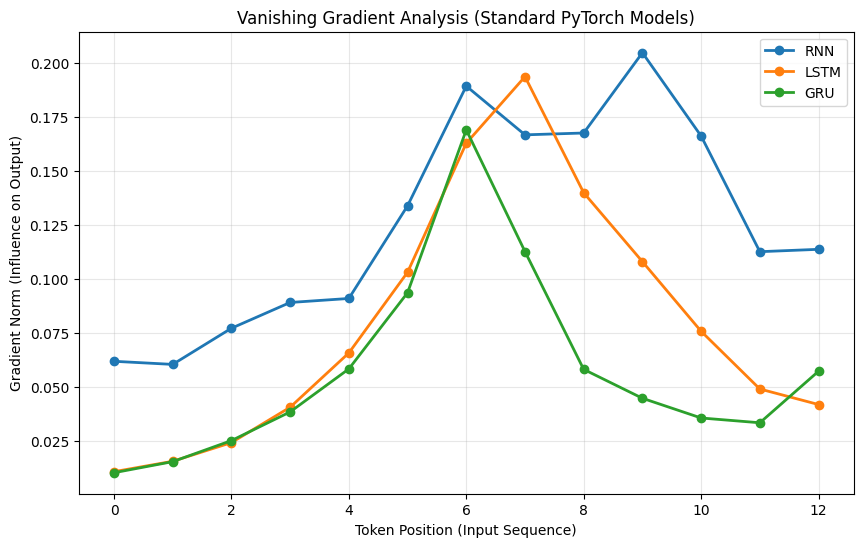

In [134]:
analyze_vanishing_gradient_torch(X_train, y_train, token2id)


=== Анализ Vanishing Gradient (Task: Name Generation) ===
Mode length: 6
Training RNN...
Training LSTM...
Training GRU...


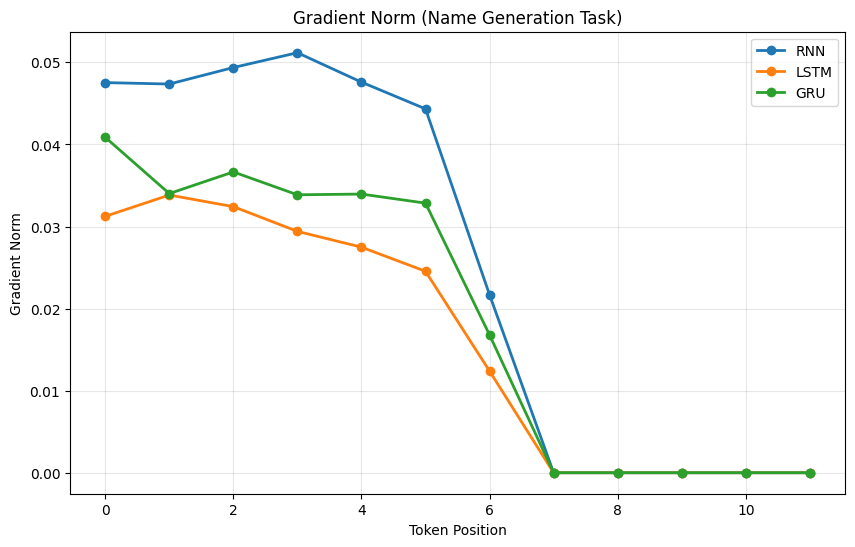

In [137]:
analyze_vanishing_gradient_torch_name(X_train, token2id)

# Multitask Learning (№10)

In [111]:
models_both = ModelRunner(['GRUBlock', 'LSTMBlock'], len(tokens))

ModelRunner инициализирован для блоков: ['GRUBlock', 'LSTMBlock']


In [112]:
models_both.train_models(train_loader, valid_loader, 25, use_next_char_loss = True, use_gender_loss = True)


Обучение GRUBlock...
Epoch 1:next_train=3.2778, next_valid=3.1278, gender_train=0.6909, gender_valid=0.6856
Epoch 10:next_train=2.3490, next_valid=2.3417, gender_train=0.4217, gender_valid=0.4510
Epoch 20:next_train=2.2328, next_valid=2.2372, gender_train=0.3805, gender_valid=0.4308
Epoch 25:next_train=2.2036, next_valid=2.2116, gender_train=0.3666, gender_valid=0.4272
GRUBlock: обучение завершено

Обучение LSTMBlock...
Epoch 1:next_train=3.2885, next_valid=3.1977, gender_train=0.6916, gender_valid=0.6900
Epoch 10:next_train=2.4060, next_valid=2.4010, gender_train=0.4371, gender_valid=0.4636
Epoch 20:next_train=2.2890, next_valid=2.2964, gender_train=0.3785, gender_valid=0.4441
Epoch 25:next_train=2.2581, next_valid=2.2673, gender_train=0.3629, gender_valid=0.4275
LSTMBlock: обучение завершено


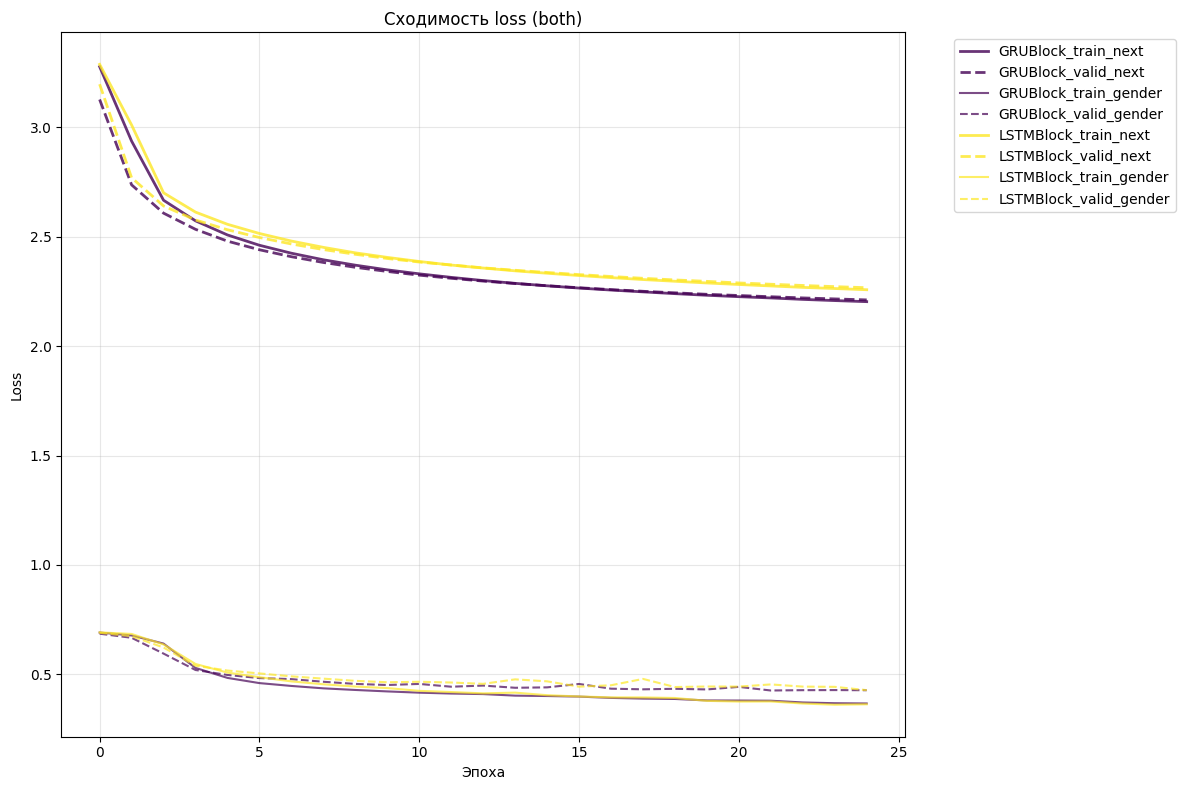

In [113]:
models_both.plot_losses(loss_type='both')

In [114]:
models_both.generate_names_comparison(token2id=token2id, id2token=id2token)


Сгенерированные имена:


,temp_0.7,temp_1.0,temp_1.3
GRUBlock,"teyre, arite, anelle, elello, arlie","any, gord, aharatde, rasess, orea","olluv, dyomim, wsisa, antaner, zelon"
LSTMBlock,"tiche, lonida, matet, aante, ruoldona","arishsenethe, arienrina, dory, ponira, aholdeiner","mallxax, amhoey, allyone, eerehndoby, shgri"


In [115]:
models_both.compute_roc_auc(test_loader)


ROC AUC по моделям:


,train_roc_auc,valid_roc_auc,test_roc_auc
GRUBlock,0.919,0.883,0.917
LSTMBlock,0.927,0.884,0.919


In [ ]:
torch.save(models_both.models_gender["LSTMBlock"], r"saved_model/full_model.pkl")

# embeddings (№11)

Используем модель: LSTMBlock
Обучаем PCA...
Обучаем t-SNE...


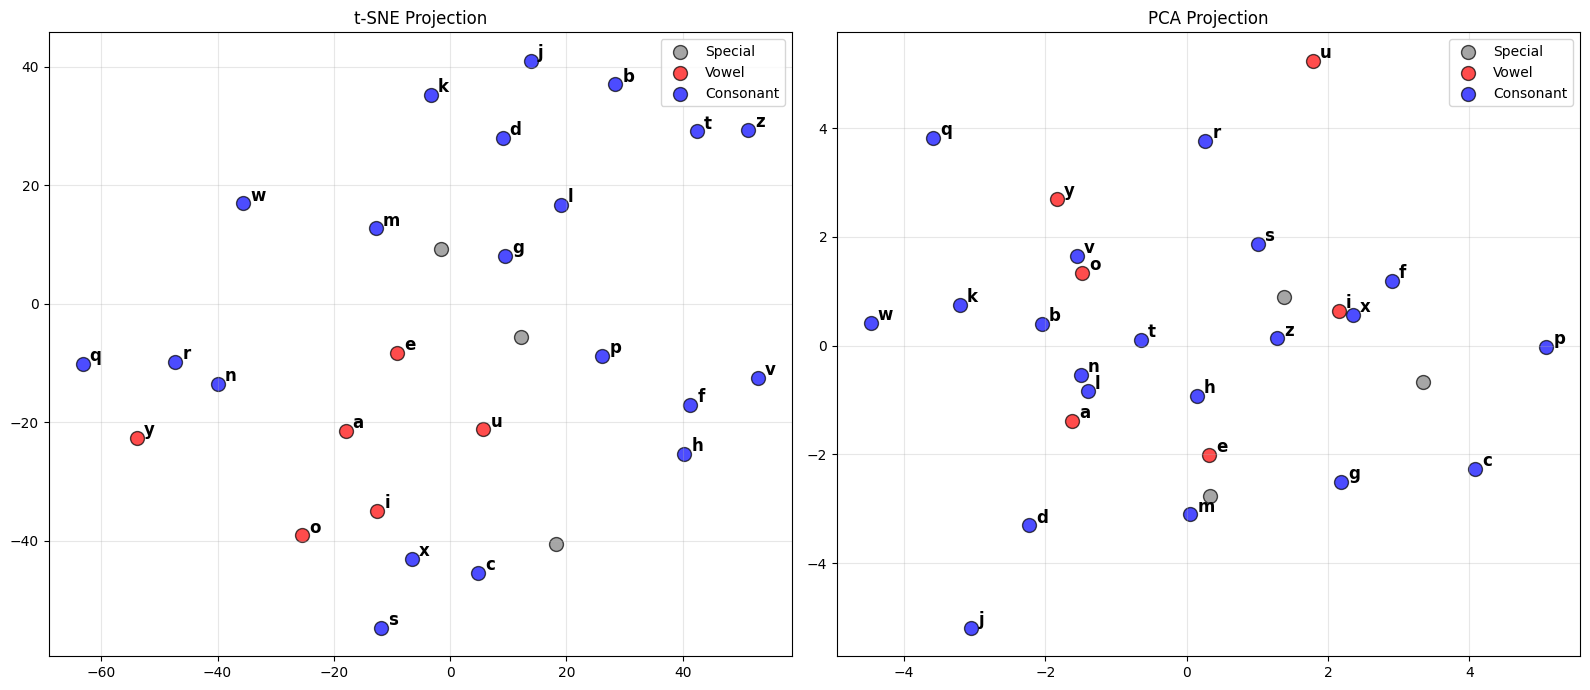

In [119]:
models_both.visualize_embeddings(id2token, "LSTMBlock")